# Training DNN Model

In this notebook, we are going to train our DNN Model with historical EUR/USD data from May 2015 - Aug 2023. 

In [1]:
from DNNModel import *
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('../data/EURUSD_HOUR.csv', parse_dates=['time'], index_col='time')
dataset = data.rename(columns={'price': 'Price'})
print(dataset)

                       Price
time                        
2015-05-15 13:00:00  1.13546
2015-05-15 14:00:00  1.14378
2015-05-15 15:00:00  1.14282
2015-05-15 16:00:00  1.14320
2015-05-15 17:00:00  1.14368
...                      ...
2023-08-01 10:00:00  1.09822
2023-08-01 11:00:00  1.09756
2023-08-01 12:00:00  1.09565
2023-08-01 13:00:00  1.09752
2023-08-01 13:00:00  1.09753

[51790 rows x 1 columns]


Above we have parsed the dataset into a DataFrame, setting the index as time. As we can see from the head/tail of the dataset, our dataset contains 51790 entries, ranging from 2015-05-15 to 2023-08-01 with a 1-hour granularity.

### Features

In [3]:
df = dataset.copy()
WINDOW = 50
FAST_SMA = 75
SLOW_SMA = 150
FAST_EMA = 12
SLOW_EMA = 26
SIGNAL_EMA = 9
RSI_WINDOW = 14

# Log Returns
df['Returns'] = np.log(df['Price'] / df['Price'].shift(1))
# Direction for class weight balancing to eliminate buy bias
df['Direction'] = np.where(df['Returns'] > 0, 1, 0)
# MACD Growth Indicator
macd = df['Price'].ewm(span=FAST_EMA, adjust=False).mean() - df['Price'].ewm(span=SLOW_EMA, adjust=False).mean()
signal = macd.ewm(span=SIGNAL_EMA, adjust=False).mean()
df['MACD'] = macd - signal
# SMA Crossover with 75-150 Fast SMA-Slow SMA split
df['SMA Crossover'] = df['Price'].rolling(FAST_SMA).mean() - df['Price'].rolling(SLOW_SMA).mean()
# Mean Reversion (similar to Bollinger Bands) with 50-period window
df['Mean Reversion'] = (df['Price'] - df['Price'].rolling(WINDOW).mean()) / df['Price'].rolling(WINDOW).std()
# Rolling Min/Max normalization with current price
df['Rolling Min'] = (df['Price'].rolling(WINDOW).min() / df['Price']) - 1
df['Rolling Max'] = (df['Price'].rolling(WINDOW).max() / df['Price']) - 1
# Momentum
df['Momentum'] = df['Returns'].rolling(WINDOW).mean()
change = df['Price'].diff()
df['RSI'] = 100 - (100 / (1 + (change.mask(change < 0, 0.0).rolling(RSI_WINDOW).mean() / -change.mask(change > 0, -0.0).rolling(RSI_WINDOW).mean())))
# Volatility
df['Volatility'] = df['Returns'].rolling(WINDOW).std()


In [4]:
df.dropna(inplace=True)
df

,Price,Returns,Direction,MACD,SMA Crossover,Mean Reversion,Rolling Min,Rolling Max,Momentum,RSI,Volatility
time,,,,,,,,,,,
2015-05-25 16:00:00,1.09854,0.001330,1,0.000466,-0.010037,-0.937949,-0.001329,0.018861,-0.000243,48.902196,0.001643
2015-05-25 17:00:00,1.09747,-0.000974,0,0.000457,-0.009924,-1.037918,-0.000355,0.019855,-0.000274,44.183950,0.001642
2015-05-25 18:00:00,1.09794,0.000428,1,0.000479,-0.009777,-0.937183,-0.000783,0.019418,-0.000277,47.690941,0.001641
2015-05-25 19:00:00,1.09798,0.000036,1,0.000492,-0.009641,-0.895203,-0.000820,0.019381,-0.000254,47.032374,0.001637
2015-05-25 20:00:00,1.09775,-0.000209,0,0.000480,-0.009522,-0.889358,-0.000610,0.019595,-0.000280,36.050157,0.001625
...,...,...,...,...,...,...,...,...,...,...,...
2023-08-01 10:00:00,1.09822,0.000619,1,-0.000119,-0.003103,-1.479394,-0.000783,0.005117,0.000041,37.888199,0.000724
2023-08-01 11:00:00,1.09756,-0.000601,0,-0.000117,-0.003214,-1.851224,-0.000073,0.005722,0.000004,33.618234,0.000707
2023-08-01 12:00:00,1.09565,-0.001742,0,-0.000224,-0.003375,-2.662682,0.000000,0.007475,-0.000068,24.221453,0.000700


Now that our feature engineering is complete, we can see that features include a variety of indicators, including growth, volatility, and momentum indicators. Next, we need to add feature lags.

### Feature Lags


In [5]:
lags = 8
columns = []
features = ['Returns', 'Direction', 'MACD', 'SMA Crossover', 'Mean Reversion', 'Rolling Min', 'Rolling Max', 'Momentum', 'RSI', 'Volatility']

for feature in features:
    for lag in range(1, lags + 1):
        column = '{}_lag_{}'.format(feature, lag)
        df[column] = df[feature].shift(lag)
        columns.append(column)
df.dropna(inplace=True)

As we have added 8 lags to our 8 features, the input layer of our Deep Neural Network now contains 64 features to predict market direction. Next, we can start to split our dataset in preparation for model training.

### Split into Train/Test Set

In [6]:
split = int(len(df) * 0.8)
training_set = df.iloc[:split].copy()
test_set = df.iloc[split:].copy()

### Feature Scaling, Standardization

In [7]:
mu = training_set.mean()
sigma = training_set.std()
standardized_training_set = (training_set - mu) / sigma
standardized_training_set.describe()

,Price,Returns,Direction,MACD,SMA Crossover,Mean Reversion,Rolling Min,Rolling Max,Momentum,RSI,...,RSI_lag_7,RSI_lag_8,Volatility_lag_1,Volatility_lag_2,Volatility_lag_3,Volatility_lag_4,Volatility_lag_5,Volatility_lag_6,Volatility_lag_7,Volatility_lag_8
count,4.130600e+04,4.130600e+04,4.130600e+04,4.130600e+04,4.130600e+04,4.130600e+04,4.130600e+04,4.130600e+04,4.130600e+04,4.130600e+04,...,4.130600e+04,4.130600e+04,4.130600e+04,4.130600e+04,4.130600e+04,4.130600e+04,4.130600e+04,4.130600e+04,4.130600e+04,4.130600e+04
mean,-1.606316e-15,2.945830e-18,-2.808214e-17,1.098773e-17,-1.720193e-19,-2.941529e-17,-1.862969e-16,-1.419159e-16,2.038428e-17,-3.694114e-16,...,1.137047e-16,6.046477e-17,-2.872722e-17,2.246571e-16,-2.769510e-16,-3.780983e-16,6.055078e-17,-2.322260e-17,-2.306778e-16,7.018386e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-2.297082e+00,-2.088625e+01,-9.872383e-01,-1.377070e+01,-4.386479e+00,-4.607530e+00,-9.281603e+00,-1.015874e+00,-5.500966e+00,-2.854285e+00,...,-2.854231e+00,-2.854228e+00,-1.736774e+00,-1.736771e+00,-1.736768e+00,-1.736764e+00,-1.736757e+00,-1.736751e+00,-1.736744e+00,-1.736734e+00
25%,-7.085598e-01,-4.047052e-01,-9.872383e-01,-5.198424e-01,-6.551521e-01,-7.863928e-01,-4.329648e-01,-7.213759e-01,-6.158568e-01,-7.400586e-01,...,-7.400708e-01,-7.400680e-01,-6.262403e-01,-6.262760e-01,-6.263113e-01,-6.263463e-01,-6.263810e-01,-6.264161e-01,-6.264512e-01,-6.264833e-01
50%,-1.813916e-01,-6.985392e-04,-9.872383e-01,2.488310e-02,-2.889250e-02,-1.020646e-02,2.649205e-01,-2.431701e-01,-1.369756e-02,1.865814e-03,...,1.903497e-03,1.010428e-03,-2.039489e-01,-2.039539e-01,-2.039924e-01,-2.040255e-01,-2.040339e-01,-2.040436e-01,-2.040418e-01,-2.040274e-01
75%,8.071584e-01,4.088925e-01,1.012902e+00,5.409123e-01,6.235705e-01,7.870434e-01,7.298309e-01,4.219302e-01,5.955342e-01,7.364866e-01,...,7.365201e-01,7.365230e-01,3.227670e-01,3.227192e-01,3.227097e-01,3.227048e-01,3.226695e-01,3.226175e-01,3.225609e-01,3.224985e-01
max,2.512341e+00,1.614029e+01,1.012902e+00,1.038152e+01,4.771959e+00,4.518925e+00,1.011859e+00,9.058693e+00,6.458952e+00,2.844420e+00,...,2.844442e+00,2.844444e+00,8.577658e+00,8.577305e+00,8.576952e+00,8.576588e+00,8.576213e+00,8.575835e+00,8.575455e+00,8.575067e+00


After splitting our data into training/test datasets, we standardized our training set. As depicted in the table, the means of all features hover around 0, whereas the standard deviations are all equal to 1. 

### Create & Fit DNN Model

In [8]:
set_seeds(100)
model = create_model(hl=3, hu=50, dropout=True, input_dim=len(columns))
model.fit(x=standardized_training_set[columns], y=training_set['Direction'], epochs=225, verbose=False, validation_split=0.2, shuffle=False, class_weight=cw(training_set))

In [9]:
model.evaluate(standardized_training_set[columns], training_set['Direction'])

1291/1291 [==============================] - 2s 1ms/step - loss: 0.6771 - accuracy: 0.5789


[0.6770943403244019, 0.5789231657981873]

1291/1291 [==============================] - 2s 2ms/step


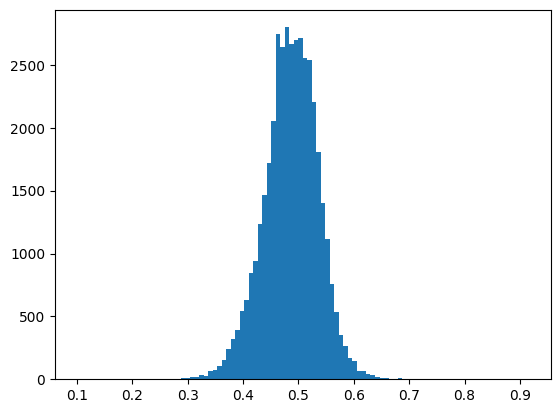

In [10]:
prediction = model.predict(standardized_training_set[columns])
plt.hist(prediction, bins=100)
plt.show()

After training and fitting the model, we see that our initial accuracy is 55.45%, which ensures that our model isn't overfitted. We can probably increase the accuracy by optimizing hyperparameters.

Moreover, we see that our predictions are normally distributed about 0.5, which is expected.

### Out-Sample Predictions

323/323 [==============================] - 0s 1ms/step


(array([  2.,   0.,   0.,   0.,   0.,   2.,   0.,   0.,   1.,   0.,   1.,
          1.,   2.,   2.,   2.,   3.,   1.,   4.,   6.,   5.,   8.,   9.,
         10.,   9.,  21.,  16.,  21.,  25.,  31.,  34.,  42.,  52.,  60.,
         68.,  97.,  93., 113., 149., 164., 191., 223., 253., 267., 324.,
        347., 361., 392., 454., 412., 389., 449., 460., 457., 458., 413.,
        453., 397., 394., 337., 305., 299., 243., 212., 168., 123., 101.,
         89.,  64.,  47.,  38.,  37.,  29.,  16.,  11.,  11.,  12.,   3.,
          6.,  10.,   2.,   3.,   4.,   2.,   1.,   0.,   0.,   1.,   0.,
          1.,   1.,   1.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([0.19793543, 0.20362611, 0.20931681, 0.21500748, 0.22069818,
        0.22638886, 0.23207955, 0.23777023, 0.24346091, 0.2491516 ,
        0.25484228, 0.26053298, 0.26622367, 0.27191433, 0.27760503,
        0.28329572, 0.28898638, 0.29467708, 0.30036777, 0.30605844,
        0.31174913, 0.31743982, 0.32313052, 0.

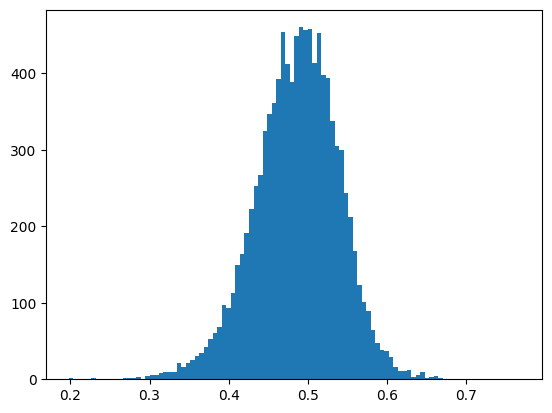

In [11]:
standardized_test_set = (test_set - mu) / sigma
model.evaluate(standardized_test_set[columns], test_set['Direction'])
os_prediction = model.predict(standardized_test_set[columns])
plt.hist(os_prediction, bins=100)

Our out-sample predictions on test set is also normally distributed about 0.5. 

### Save Model and Parameters

In [12]:
model.save('DNN_Save')

INFO:tensorflow:Assets written to: DNN_Save\assets


INFO:tensorflow:Assets written to: DNN_Save\assets


In [13]:
parameters = {'mu': mu, 'sigma': sigma}
pickle.dump(parameters, open('parameters.pkl', 'wb'))